# 자동차 파손 영역 검사 및 가격 산출 AI 만들기

### 참조 : [AI허브](https://www.aihub.or.kr), [쏘카](https://www.socar.kr)

In [4]:
import torch
import cv2
import matplotlib.pyplot as plt

from src.Models import Unet

## 모델 로드

- `[DAMAGE][Breakage_3]Unet.pt` : 파손
- `[DAMAGE][Crushed_2]Unet.pt` : 찌그러짐
- `[DAMAGE][Scratch_0]Unet.pt` : 스크래치
- `[DAMAGE][Seperated_1]Unet.pt` : 이격
- `[PART]Unet.pt` : 자동차 부위 영역

### 사전 학습 모델 다운로드

https://drive.google.com/drive/folders/1q0l5vT14Kka_iu0WZgn1EFJLUbWD8EtY?usp=sharing

### 데이터셋

[차량 파손 이미지 - AI허브](https://www.aihub.or.kr/aihubdata/data/view.do?dataSetSn=581)

In [5]:
# weight_path = '../models/[DAMAGE][Breakage_3]Unet.pt'
# weight_path = '../models/[DAMAGE][Crushed_2]Unet.pt'
# weight_path = '../models/[DAMAGE][Scratch_0]Unet.pt'
# weight_path = '../models/[DAMAGE][Seperated_1]Unet.pt'
weight_path = '../models/[PART]Unet.pt'


n_classes = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
model.model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))
model.eval()

print('Loaded pretrained model!')

Loaded pretrained model!


## 이미지 로드

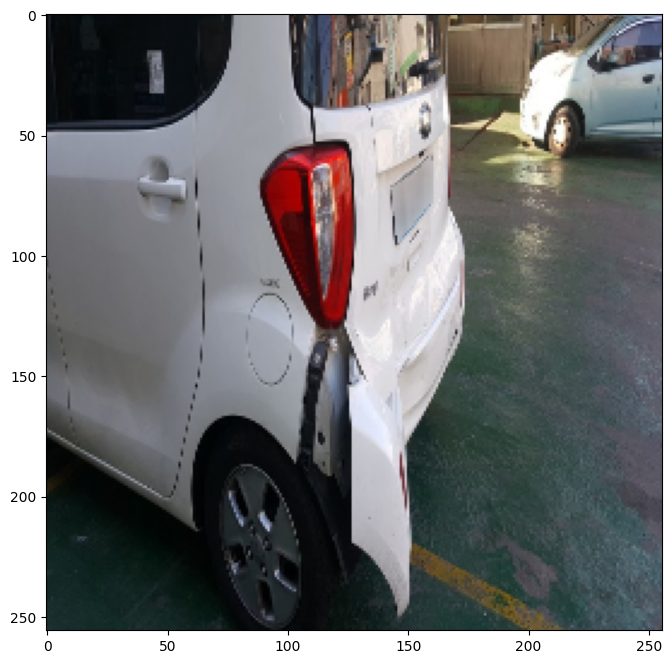

In [6]:
# img_path = '../samples/damage/0000002_as-0036229.jpg' # Breakage
# img_path = '../samples/damage/0000565_sc-163434.jpg' # Scratch
img_path = '../444.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

plt.figure(figsize=(8, 8))
plt.imshow(img)

## 저조도 사진 개선

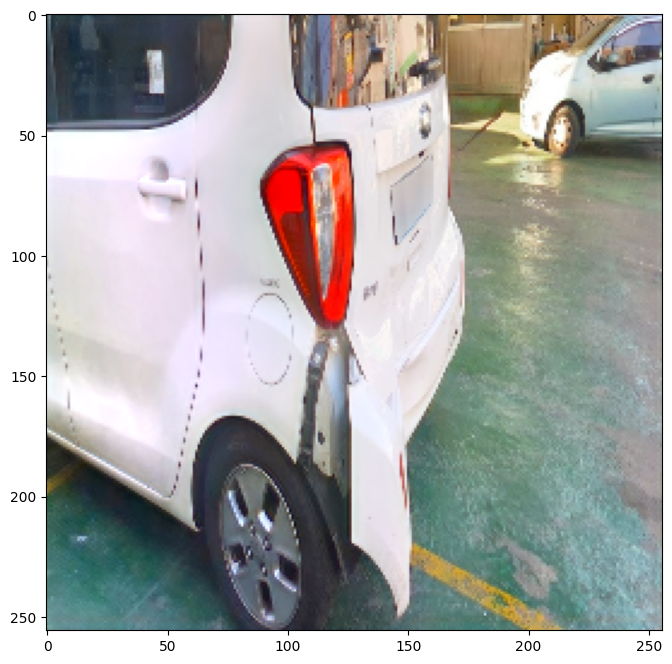

In [7]:
from enlighten_inference import EnlightenOnnxModel
# pip install git+https://github.com/arsenyinfo/EnlightenGAN-inference

model_light = EnlightenOnnxModel()
img = model_light.predict(img)
plt.figure(figsize=(8, 8))
plt.imshow(img)

## 이미지 전처리

In [8]:
img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

img_input.shape

torch.Size([1, 3, 256, 256])

## 모델 추론

In [9]:
output = model(img_input)

output.shape

torch.Size([1, 16, 256, 256])

## 후처리 및 추론 마스크 시각화

33924

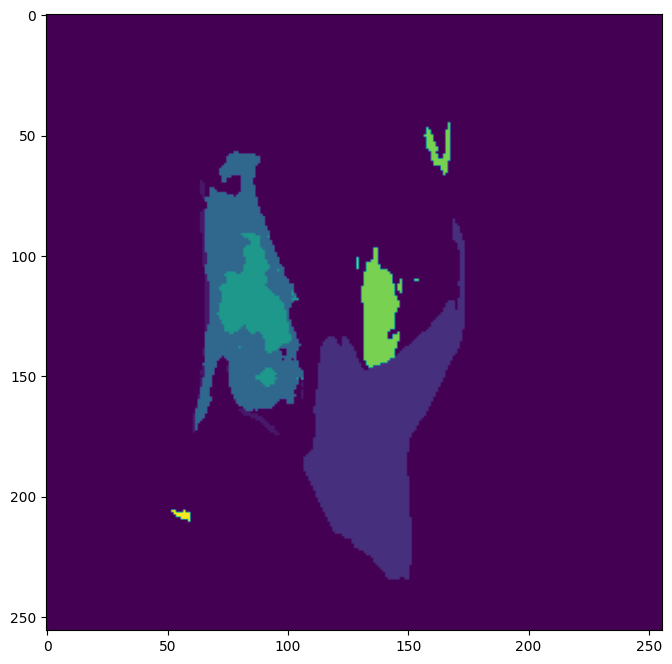

In [10]:
img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
img_output = img_output.transpose([1, 2, 0])

# plt.figure(figsize=(8, 8))
# plt.imshow(img_output)
img_output.sum()

## 결과

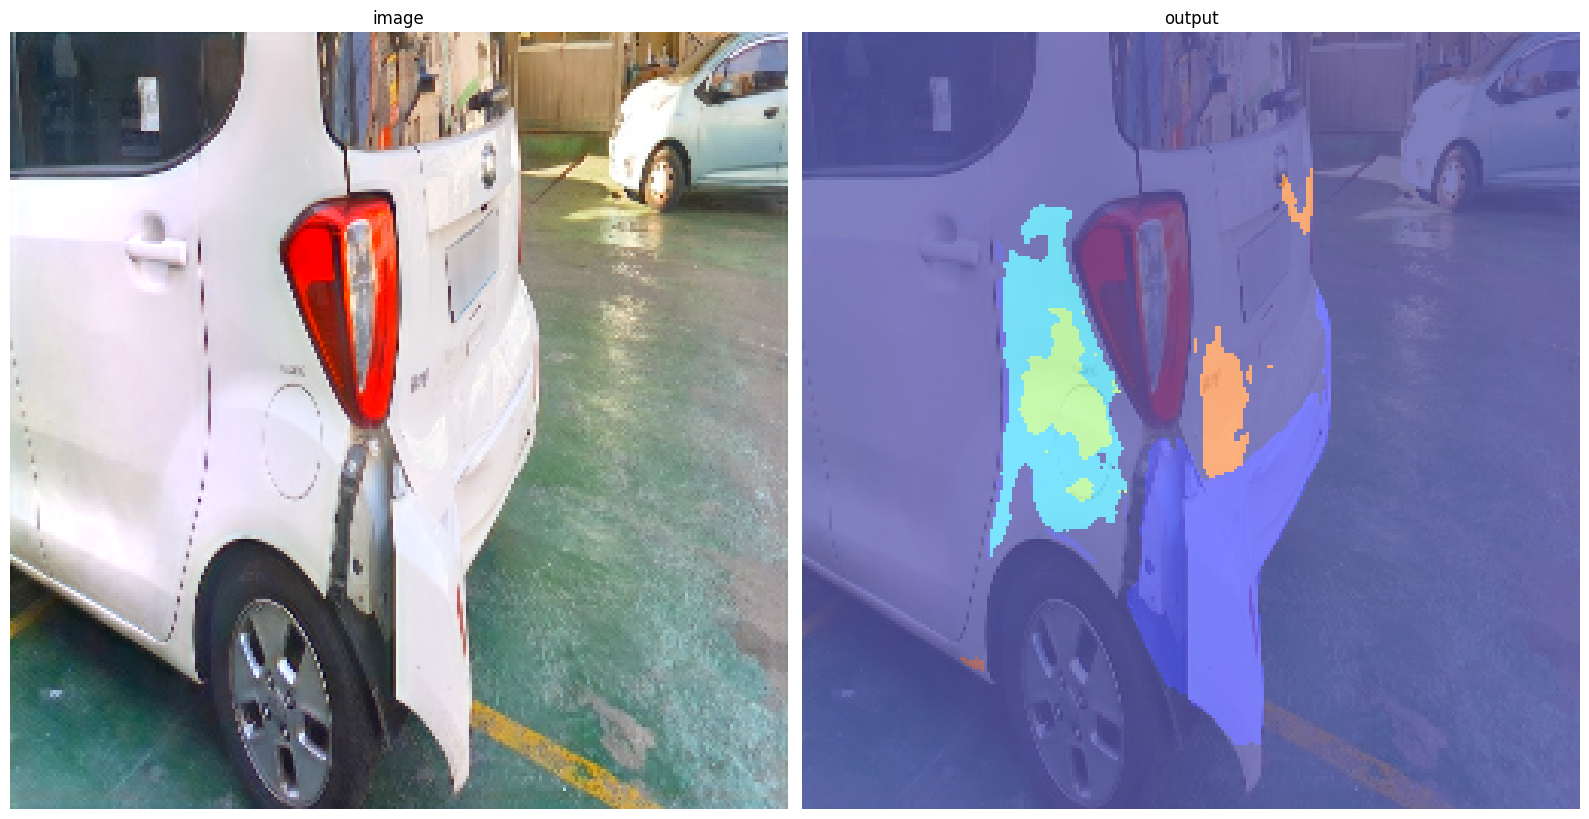

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

ax[0].imshow(img)
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(img.astype('uint8'), alpha=0.5)
ax[1].imshow(img_output, cmap='jet', alpha=0.5)
ax[1].set_title('output')
ax[1].axis('off')

fig.set_tight_layout(True)
plt.show()

# 여러 형태의 파손 영역 감지

In [12]:
labels = ['Breakage_3', 'Crushed_2', 'Scratch_0', 'Seperated_1']
models = []

n_classes = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for label in labels:
    model_path = f'../models/[DAMAGE][{label}]Unet.pt'

    model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
    model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    models.append(model)

print('Loaded pretrained models!')

Loaded pretrained models!


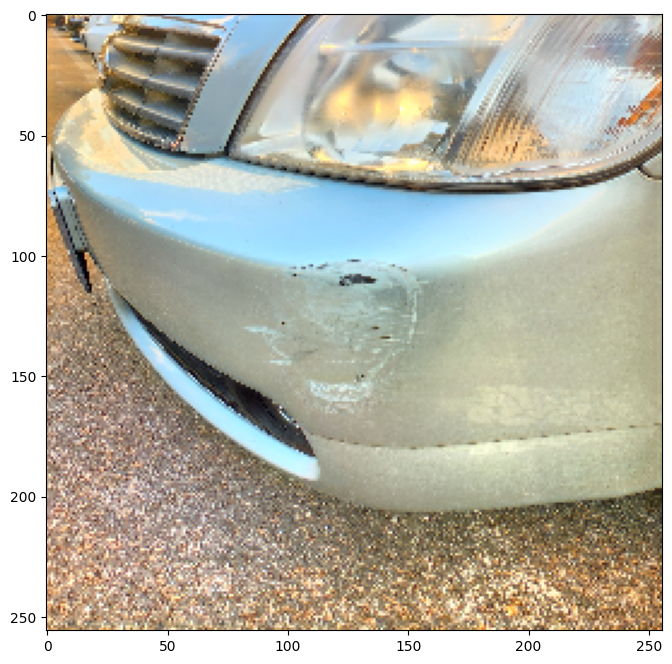

In [13]:
img_path = '../111.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

model_light = EnlightenOnnxModel()
img = model_light.predict(img)

plt.figure(figsize=(8, 8))
plt.imshow(img)

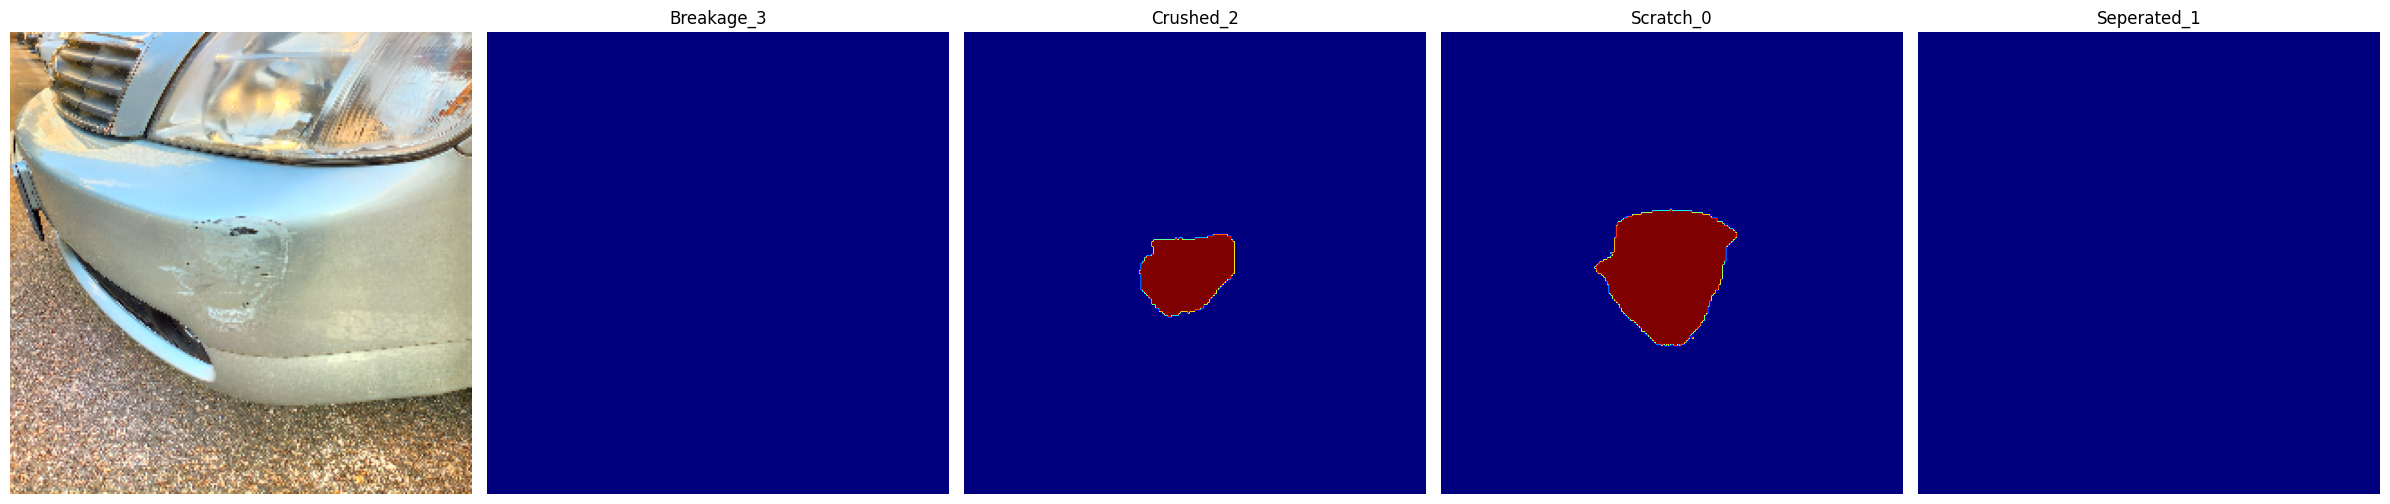

In [14]:
img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

fig, ax = plt.subplots(1, 5, figsize=(24, 10))

ax[0].imshow(img)
ax[0].axis('off')

outputs = []

for i, model in enumerate(models):
    output = model(img_input)

    img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
    img_output = img_output.transpose([1, 2, 0])

    outputs.append(img_output)

    ax[i+1].set_title(labels[i])
    ax[i+1].imshow(img_output, cmap='jet')
    ax[i+1].axis('off')

fig.set_tight_layout(True)
plt.show()

##  파손 영역 크기 계산

In [15]:
for i, label in enumerate(labels):
    print(f'{label}: {outputs[i].sum()}')

Breakage_3: 0
Crushed_2: 1792
Scratch_0: 3938
Seperated_1: 0


## 파손 영역 크기에 따른 가격 산출 (예시)

1픽셀당 가격을 책정하여 영역이 넓을 수록 수리비용이 비싸진다

In [16]:
price_table = [
    200, # Breakage_3 / 파손 200
    150, # Crushed_2 / 찌그러짐 150
    100,  # Scratch_0 / 스크래치 100
    200, # Seperated_1 / 이격 200
]

total = 0

for i, price in enumerate(price_table):
    area = outputs[i].sum()
    total += area * price

    print(f'{labels[i]}:\t영역: {area}\t가격:{area * price}원')

print(f'고객님, 총 수리비는 {total}원 입니다!')

Breakage_3:	영역: 0	가격:0원
Crushed_2:	영역: 1792	가격:268800원
Scratch_0:	영역: 3938	가격:393800원
Seperated_1:	영역: 0	가격:0원
고객님, 총 수리비는 662600원 입니다!


## 손상심각도 계산

In [17]:
# 전체 면적 계산
weight_path = '../models/[PART]Unet.pt'

n_classes = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
model.model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))
model.eval()

img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

output = model(img_input)

img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
img_output = img_output.transpose([1, 2, 0])

area_sum = img_output.sum()

# 각각 손상부위별 면적
area_breakage = outputs[0].sum()
area_crushed = outputs[1].sum()
area_scratch = outputs[2].sum()
area_seperated = outputs[3].sum()
print(area_sum, area_breakage, area_crushed, area_scratch, area_seperated)

39112 0 1792 3938 0


In [18]:
severity = (area_breakage*3.0 + area_crushed*2.0 + area_seperated*1.2 + area_scratch*1.0) * 100 / (3*area_sum)
severity

6.410649757960046

In [19]:
if 0 <= severity < 11:
    level = 4
elif  severity < 41:
    level = 3
elif  severity < 81:
    level = 2
else:
    level = 1

print('손상심각도 :', level, '등급')

손상심각도 : 4 등급
